#Test data trajectory analysis

To generate synthetic sequences we need "paths" that control the movement of the object in the scene. The most obvious source for a generative model for "natural" paths are the test sequences inside the tracking datasets. 

The are many ways to analyze this data. We will try some of these alternatives, starting by a mapping to our synthetic generation model i.e. 5 degrees of freedom (DOF) corresponding to rotation, scaling and translation. The first point analyzed was that as the ground truth bounding boxes are axis-aligned, it is difficult to infer rotation information directly from the box. Therefore, our first visualizations belong to only scaling and translation transformations i.e. 4 DOF.

In [41]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [42]:
from PIL import Image, ImageDraw
import numpy
import os
import matplotlib
import matplotlib.pyplot
import IPython.display
import animator

In [43]:
#Helper functions

def read_gt(gtPath):
    gtFile = open(gtPath, 'r')
    lines = gtFile.xreadlines()
    #TODO: better replacement of whitespace
    gt = [map(float, line.strip().replace(',', ' ').split()) for line in lines]
    gtFile.close()
    return gt

In [44]:
def draw_polygon(imagePath, polygon):
    image = Image.open(imagePath)
    draw = ImageDraw.ImageDraw(image)
    draw.polygon(polygon)
    return image

In [45]:
def homogeneous_points(coordinates, dims=2):
    values = numpy.reshape(coordinates, (len(coordinates)/2, dims)).T
    points = numpy.vstack([values, numpy.ones((1, values.shape[1]))])
    return points

In [46]:
#NOTE: Depends on transformation order: T*S*R
def transform_params(transform, prevAngle=None):
    x = transform[0,-1]
    y = transform[1,-1]
    originalTheta = numpy.arctan2(transform[0,1],transform[0,0])
    theta = originalTheta
    if prevAngle is not None:
        n = numpy.around((prevAngle - theta)/numpy.pi)
        theta += n*numpy.pi
    ratio1 = numpy.abs(transform[0,0]/transform[1,1])
    ratio2 = numpy.abs(transform[0,1]/transform[1,0])
    if numpy.abs(numpy.cos(theta)) >= numpy.abs(numpy.sin(theta)):
        ratio = ratio1
    else:
        ratio = ratio2
    product = numpy.abs(transform[0,0])*numpy.abs(transform[1,1])+numpy.abs(transform[0,1])*numpy.abs(transform[1,0])
    #print 'Product: {}\tRatio: {}\tDividends: {}, {}\tTheta: {}\t Cos: {}\tSin: {}'.format(product, ratio, transform[0,0], transform[1,1], theta, numpy.cos(theta), numpy.sin(theta))
    sy = numpy.sqrt(product/ratio)
    sx = ratio*sy
    return x,y,sx,sy,theta,originalTheta

In [47]:
gtPath = '/home/fmpaezri/datasets/vot-challenge/sequences/diving/groundtruth.txt'
gt = read_gt(gtPath)

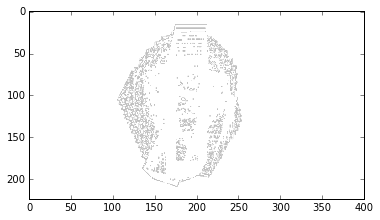

In [48]:
frameSize = Image.open(os.path.join(os.path.dirname(gtPath), '00000001.jpg')).size
image = Image.new('RGBA', frameSize)
canvas = ImageDraw.ImageDraw(image)
for box in gt:
    canvas.polygon(box)
matplotlib.pyplot.imshow(numpy.asarray(image))

In [49]:
output = '/tmp/video.mp4'
sequence = (draw_polygon(os.path.join(os.path.dirname(gtPath), imagePath), gt[i]) for i, imagePath in enumerate(sorted(os.listdir(os.path.dirname(gtPath)))) if imagePath.endswith('.jpg'))
%time animator.frames2video(sequence, 30, output)
videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
IPython.display.HTML(videoTag.format(videoSrc))

CPU times: user 1.24 s, sys: 4 ms, total: 1.24 s
Wall time: 2.11 s


In [50]:
refPoints = homogeneous_points(gt[0])
refPoints = refPoints-numpy.array([[numpy.min(refPoints[0,:]), numpy.min(refPoints[1,:]), 0]]).T
path = numpy.empty((0,6))
averageDiff = 0
previousTheta = None
predictedPointsList = \[refPoints[:2,:].T.flatten()]
transformedPointsList = [refPoints[:2,:].T.flatten()]
for i in range(1,len(gt)):
    points = homogeneous_points(gt[i])
    transform = numpy.dot(points, numpy.linalg.pinv(refPoints))
    transformedPoints = numpy.dot(transform, refPoints)
    transformedPointsList.append(transformedPoints[:2,:].T.flatten())
    params = transform_params(transform, prevAngle=previousTheta)
    path = numpy.vstack([path, params])
    tx, ty, sx, sy, theta, originalTheta = params
    previousTheta = theta
    predictedTransform = numpy.array([[sx*numpy.cos(theta), sx*numpy.sin(theta), tx],[-sy*numpy.sin(theta), sy*numpy.cos(theta), ty],[0,0,1]])
    predictedPoints = numpy.dot(predictedTransform, refPoints)
    predictedPointsList.append(predictedPoints[:2,:].T.flatten())
    currentDiff = numpy.linalg.norm(points-predictedPoints)
    #print 'Current difference[{}]: {}\n{}\n{}'.format(i, currentDiff, transform, predictedTransform)
    averageDiff += currentDiff
averageDiff /= len(gt)-1
print 'Average difference: {}'.format(averageDiff)

Average difference: 58.3369749492


In [54]:
print gt[0]
print refPoints

[174.5, 179.0, 174.5, 17.0, 211.5, 17.0, 211.5, 179.0]
[[   0.    0.   37.   37.]
 [ 162.    0.    0.  162.]
 [   1.    1.    1.    1.]]


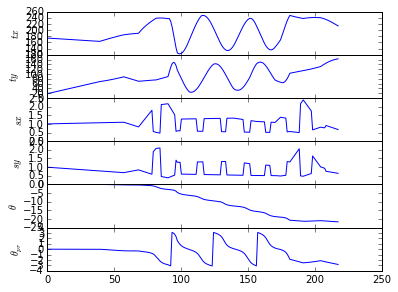

In [52]:
titles = ['$ tx $', '$ ty $', '$ sx $', '$ sy $', '$ \\theta $', '$ \\theta_{pr}$']
matplotlib.pyplot.gcf().subplots_adjust(bottom=0.0, hspace=0.0)
for i in range(path.shape[1]):
    axes = matplotlib.pyplot.subplot(path.shape[1],1,i+1)
    matplotlib.pyplot.plot(path[:,i])
    if i < path.shape[1]-1:
        matplotlib.pyplot.setp( axes.get_xticklabels(), visible=False)
    matplotlib.pyplot.ylabel(titles[i])
#matplotlib.pyplot.tight_layout()

In [53]:
output = '/tmp/video.mp4'
sequence = (draw_polygon(os.path.join(os.path.dirname(gtPath), imagePath), predictedPointsList[i].tolist()) for i, imagePath in enumerate(sorted(os.listdir(os.path.dirname(gtPath)))) if imagePath.endswith('.jpg'))
%time animator.frames2video(sequence, 30, output)
videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
IPython.display.HTML(videoTag.format(videoSrc))

CPU times: user 1.26 s, sys: 8 ms, total: 1.27 s
Wall time: 2.16 s
